<a href="https://colab.research.google.com/github/parabola01/deep_neural_networks/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

# Define a basic residual block
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same")
        self.norm1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same")
        self.norm2 = layers.BatchNormalization()

        # Shortcut path for downsampling
        self.downsample = None
        if stride != 1:
            self.downsample = models.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same"),
                layers.BatchNormalization()
            ])

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.norm1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.norm2(x, training=training)

        shortcut = inputs
        if self.downsample:
            shortcut = self.downsample(inputs, training=training)

        x += shortcut
        x = tf.nn.relu(x)
        return x

In [7]:
class ResNet(tf.keras.Model):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()

        self.conv1 = layers.Conv2D(16, kernel_size=3, strides=1, padding="same")
        self.norm1 = layers.BatchNormalization()

        # Residual block layers
        self.layers_residuals = self._build_residual_layers(num_blocks)

        # Global average pooling and final dense layer
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation="softmax")

    def _build_residual_layers(self, num_blocks):
        filters = [16, 32, 64]
        layers_list = []

        for i, f in enumerate(filters):
            if i != 0:
              stride = 2
            else:
              stride = 1
            layers_list.append(ResidualBlock(f, stride=stride))

            # Add additional residual blocks with stride 1
            for _ in range(1, num_blocks[i]):
                layers_list.append(ResidualBlock(f, stride=1))

        return layers_list

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.norm1(x, training=training)
        x = tf.nn.relu(x)
        # Apply residual blocks
        for block in self.layers_residuals:
            x = block(x, training=training)

        x = self.global_avg_pool(x)
        x = self.fc(x)
        return x


In [8]:
def resnet_54(num_classes=10):
    return ResNet(num_blocks=[8, 9, 9], num_classes=num_classes)

def resnet_56(num_classes=10):
    return ResNet(num_blocks=[9, 9, 9], num_classes=num_classes)

In [9]:
# Create and compile the model
model_54 = resnet_54(num_classes=10)  # Adjust number of classes as needed
model_56 = resnet_56(num_classes=10)

In [10]:
# Compile models
model_54.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_56.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train ResNet-54 on CIFAR-10
history_54 = model_54.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=64)

# Train ResNet-56 on CIFAR-10
history_56 = model_56.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=64)


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 64ms/step - accuracy: 0.3780 - loss: 1.7315 - val_accuracy: 0.4707 - val_loss: 1.5642
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6400 - loss: 1.0098 - val_accuracy: 0.5833 - val_loss: 1.2755
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.7186 - loss: 0.7978 - val_accuracy: 0.6578 - val_loss: 1.0392
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.7671 - loss: 0.6627 - val_accuracy: 0.7275 - val_loss: 0.8203
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.8039 - loss: 0.5576 - val_accuracy: 0.7454 - val_loss: 0.7462
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.8306 - loss: 0.4958 - val_accuracy: 0.7012 - val_loss: 0.9878
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8487 - loss: 0.4370 - val_accuracy: 0.7175 - val_loss: 0.9541
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.8675 - loss: 0.3833 -

In [11]:
import matplotlib.pyplot as plt

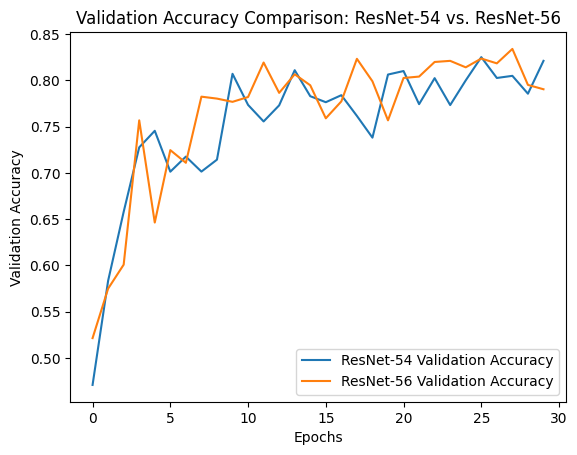

In [12]:
# Compare validation accuracy of both models
plt.plot(history_54.history['val_accuracy'], label='ResNet-54 Validation Accuracy')
plt.plot(history_56.history['val_accuracy'], label='ResNet-56 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison: ResNet-54 vs. ResNet-56')
plt.legend()
plt.show()

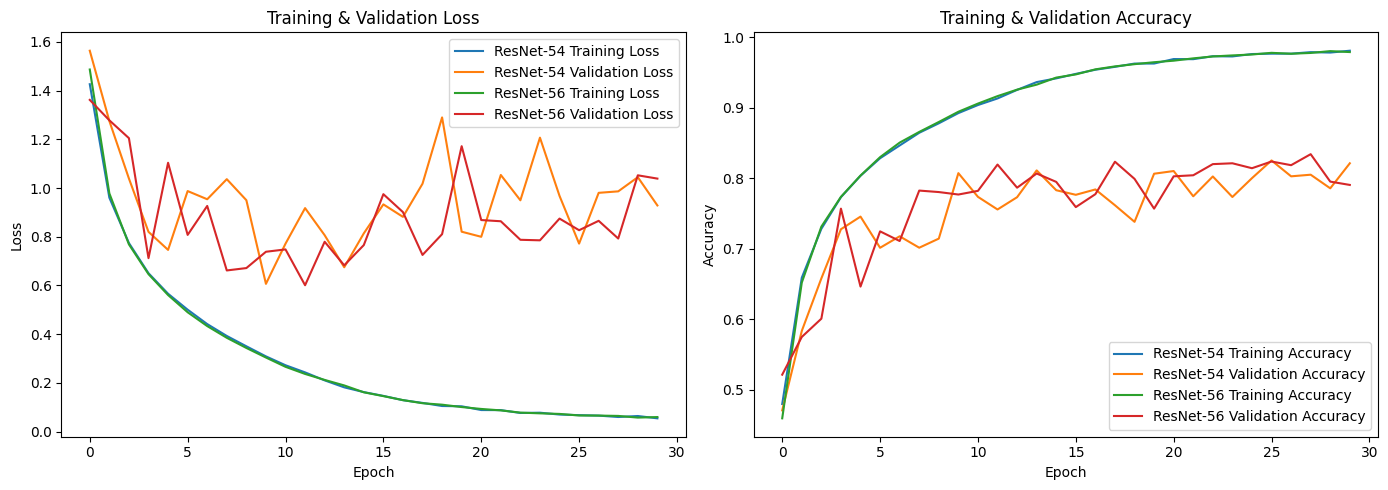

In [13]:
plt.figure(figsize=(14, 5))

# 1. Wykres loss (training i validation) dla obu modeli
plt.subplot(1, 2, 1)
plt.plot(history_54.history['loss'], label='ResNet-54 Training Loss')
plt.plot(history_54.history['val_loss'], label='ResNet-54 Validation Loss')
plt.plot(history_56.history['loss'], label='ResNet-56 Training Loss')
plt.plot(history_56.history['val_loss'], label='ResNet-56 Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Wykres accuracy (training i validation) dla obu modeli
plt.subplot(1, 2, 2)
plt.plot(history_54.history['accuracy'], label='ResNet-54 Training Accuracy')
plt.plot(history_54.history['val_accuracy'], label='ResNet-54 Validation Accuracy')
plt.plot(history_56.history['accuracy'], label='ResNet-56 Training Accuracy')
plt.plot(history_56.history['val_accuracy'], label='ResNet-56 Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()